<IMG SRC="https://github.com/jacquesroy/byte-size-data-science/raw/master/images/Banner.png" ALT="BSDS Banner" WIDTH=1195 HEIGHT=200>

<table align="left">
    <tr><td>
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a></td><td>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.</td>
    </tr>
    <tr><td>Jacques Roy, Byte Size Data Science</td><td> </td></tr>
    </table>

# DBSCAN
Density-based spatial clustering. Locates regions of high density that are separated from one another by regions of low density.

info:

- https://scikit-learn.org/stable/modules/clustering.html#clustering
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster
- https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
- https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

In [ ]:
# youtube video related to this notebook
from IPython.display import IFrame

IFrame(src="https://www.youtube.com/embed/3k68cUIUuqs?rel=0&amp;controls=0&amp;showinfo=0", width=560, height=315)

In [1]:
# Library used to read datasets
# https://github.com/xmunoz/sodapy
!pip install sodapy 2>&1 >pipsodapy.txt

In [2]:
# Install geopandas for geo objects support
!pip install geopandas 2>&1 >pipgeopandas.txt

In [3]:
# Install folium for map rendering
!pip install folium 2>&1 >foliumpip.out

In [4]:
# Libraries needed in the notebook
# import urllib3, requests, json
import pandas as pd
import numpy as np
# import io

# pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
# matplotlib.patches lets us create colored patches, which we can use for legends in plots
import matplotlib.patches as mpatches
%matplotlib inline

from sodapy import Socrata
import geopandas as gp
import folium

## Getting the data
The exact same way as in notebook 76

In [5]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

In [6]:
from datetime import date
from dateutil.relativedelta import relativedelta

# If we wanted to do today:
# six_months = (date.today() - relativedelta(months=+6)).strftime('%Y-%m-%d')
# We are using a fix date for future comparisons
six_months = (date(2021,1,15) - relativedelta(months=+6)).strftime('%Y-%m-%d')
where = "crash_date > '{}'".format(six_months)

In [7]:
# https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
crashes_df = pd.DataFrame(client.get("85ca-t3if", where=where, limit=10000))
offset = 10000
result = client.get("85ca-t3if", where=where, offset=offset, limit=10000)
while (len(result) > 0) :
    crashes_df = crashes_df.append(pd.DataFrame(result), sort=True)
    offset += 10000
    result = client.get("85ca-t3if", where=where, offset=offset, limit=10000)

print("Number of records: {}, number of columns: {}".format(crashes_df.shape[0], crashes_df.shape[1]))

Number of records: 49039, number of columns: 49


## Selecting Columns

In [8]:
# Has to be a better way to do this...
crashes_df = crashes_df[['injuries_fatal','injuries_total','latitude','longitude']]
# convert 'injuries_fatal' and 'injuries_total' to float otherwide, int causes problems.
crashes_df = crashes_df.astype({'injuries_fatal': float, 'injuries_total': float,
                                'latitude': float, 'longitude': float})
crashes_df = crashes_df.dropna()
crashes_df = crashes_df[crashes_df['longitude'] != 0]
crashes_df = crashes_df[crashes_df['latitude'] != 0]

#divide dataset into accident categories: fatal, non-fatal but with injuries, none of the above
killed_df = crashes_df[crashes_df['injuries_fatal']>0]
injured_df = crashes_df[np.logical_and(crashes_df['injuries_total']>0, crashes_df['injuries_fatal']==0)]
killed_or_injured_df = killed_df.append(injured_df)
nothing_df = crashes_df[np.logical_and(crashes_df['injuries_fatal']==0, crashes_df['injuries_total']==0)]

print("Number of records: {}".format(crashes_df.shape[0]))
print("Number of fatal accidents: {}".format(killed_df.shape[0]))
print("Number of injury accidents: {}".format(injured_df.shape[0]))
print("Number of no-injury accidents: {}".format(nothing_df.shape[0]))

Number of records: 48633
Number of fatal accidents: 87
Number of injury accidents: 7617
Number of no-injury accidents: 40929


## Scatterplot

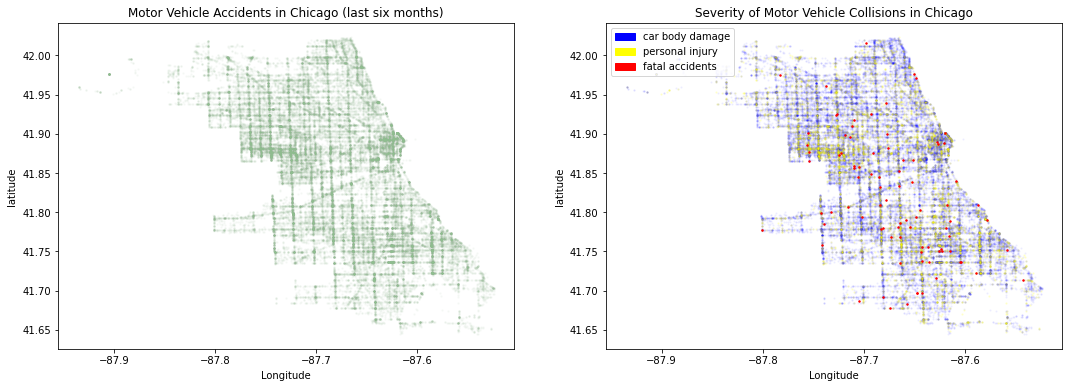

In [9]:
# I've also done subplots in notebook 61
nb_rows = 1
nb_plots = 2

fig, axes = plt.subplots(nrows=nb_rows, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(18)

axes[0].scatter(crashes_df.longitude, crashes_df.latitude, color='darkseagreen', alpha=0.05, s=2)
axes[0].title.set_text('Motor Vehicle Accidents in Chicago (last six months)')
axes[0].set_xlabel('Longitude', labelpad = 5)
axes[0].set_ylabel('latitude', labelpad = 5)


axes[1].scatter(nothing_df.longitude, nothing_df.latitude, color='blue', alpha=0.04, s=2)
axes[1].scatter(injured_df.longitude, injured_df.latitude, color='yellow', alpha=0.12, s=2)
axes[1].scatter(killed_df.longitude, killed_df.latitude, color='red', alpha=1, s=2)

#create legend
blue_patch = mpatches.Patch( label='car body damage', color='blue')
yellow_patch = mpatches.Patch(color='yellow', label='personal injury')
red_patch = mpatches.Patch(color='red', label='lethal accidents')
axes[1].legend([blue_patch, yellow_patch, red_patch],('car body damage', 'personal injury', 'fatal accidents'), 
           loc='upper left', prop={'size':10})
axes[1].title.set_text('Severity of Motor Vehicle Collisions in Chicago')
axes[1].set_xlabel('Longitude', labelpad = 5)
axes[1].set_ylabel('latitude', labelpad = 5)
plt.show()


## Recall: DBSCAN from notebook 76
In this case, we are trying to identify the intersections that have the most accidents.

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [11]:
# Should we aim for a number of clusters that is lower than the number of accidents with fatalities (<92)?
# data_np = crashes_df[['latitude','longitude']].to_numpy()

db = DBSCAN(eps=0.00015, min_samples=18).fit(crashes_df[['latitude','longitude']])

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 33
Estimated number of noise points: 47767


In [12]:
results_df = crashes_df[['latitude','longitude']].copy(deep=True)
results_df['cluster'] = db.labels_
results_df = results_df[results_df['cluster'] > -1].reset_index(drop=True) # remove noise points
results_df = results_df.groupby('cluster').agg(latitude=pd.NamedAgg(column='latitude',aggfunc="mean"), 
                                               longitude = pd.NamedAgg(column='longitude',aggfunc="mean"), 
                                               cnt = pd.NamedAgg(column='cluster', aggfunc='count') ).\
                                           reset_index().sort_values('cnt', ascending=False).reset_index(drop=True)

minval=results_df['cnt'].min().astype(int).item()
maxval= 1 + results_df['cnt'].max().astype(int).item()
# print("minval: {}, maxval: {}".format(minval,maxval))
# results_df.head()

In [13]:
# Use a colormap to colorcode the count of accidents in each cluster
# It's difficult to find a good colormap to use.
# see: https://matplotlib.org/3.3.3/gallery/color/colormap_reference.html
import matplotlib.cm as cm
import numpy as np

colors = cm.get_cmap('viridis', maxval)(range(maxval),bytes=True)

rgbcolors = []
for v in colors :
    col = np.floor(v * 255)
    r = int(col[0])
    g = int(col[1])
    b = int(col[2])
    rgbcolors.append('#' + '{0:#08x}'.format(((r * 65536) + (g * 256) + b))[2:])

In [14]:
# Display the average center of each group
latlong = results_df[['latitude','longitude']].mean(axis=0) # To center the map
chi_map = folium.Map(location=[latlong[0], latlong[1]], zoom_start=10, width="90%", height="90%")

# Since the dataframe is ordered, we can display the top 20 only
for idx, coord in results_df[0:20].iterrows():
    tooltip_content="Cluster: {0}, count: {1}".format(coord['cluster'].astype(int),coord['cnt'].astype(int) )
    folium.Circle(radius=20,
                  location=[coord['latitude'], coord['longitude']],
                  # popup=row.hgroup,
                  color=rgbcolors[coord['cnt'].astype(int) ],
                  tooltip=tooltip_content,
                  fill=True,
                  fill_color=rgbcolors[coord['cnt'].astype(int) ]
    ).add_to(chi_map)
    
chi_map

## DBSCAN
Increase the size of the eps from intersection to block.

[Wikipedia definition of a city block](https://en.wikipedia.org/wiki/City_block):
> "The standard block in Manhattan is about 264 by 900 feet (80 m × 274 m). In Chicago, a typical city block is 330 by 660 feet (100 m × 200 m), meaning that 16 east-west blocks or 8 north-south blocks measure one mile, which has been adopted by other US cities."

- Longitude: east-west
- Latitude: north-south

In the Chicago area, as noted in notebook 76, the value 0.00015 represents roughly:

- Horizontal (longitudinal) distance: 40 feet
- Vertical (latitudinal) distance: 54 feet


## Figure out a block distance
Using a cell from Notebook 45 to make sure we get the proper distance.

Based on what we just said, it should be around 8 times 0.00015

Should we also increase the "min_samples" by 8 times?

In [15]:
# Chicago area 
from geopy.distance import geodesic
dist = 0.00122
p1 = (42.0, -87.7)
p2 = (42.0, -87.7 + dist)
p3 = (42.0 + dist, -87.7)
p4 = (42.0 + dist,-87.7 + dist)

print("Horizontal (longitudinal) distance: " + str(geodesic(p1, p2).feet))
print("Vertical (latitudinal) distance: " + str(geodesic(p1, p3).feet))
print("Diagonal distance: " + str(geodesic(p1, p4).feet))

Horizontal (longitudinal) distance: 331.6205024068803
Vertical (latitudinal) distance: 444.58471270485006
Diagonal distance: 554.6400848917021


In [17]:
# Try different "min_samples": 18, 36, 54, 72
db = DBSCAN(eps=0.00122, min_samples=36).fit(crashes_df[['latitude','longitude']])

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 105
Estimated number of noise points: 42309


In [18]:
data_pd = crashes_df[['latitude','longitude']].copy(deep=True)
data_pd['cgroup'] = db.labels_
data_pd['cnt'] = [1] * db.labels_.shape[0]
# Remove group -1 (noise points)
data_pd = data_pd[data_pd['cgroup'] > -1].reset_index(drop=True)

geo_gpd = gp.GeoDataFrame(data_pd, geometry=gp.points_from_xy(data_pd.longitude, data_pd.latitude))


In [19]:
# Create shapes for each cluster
group_gpd = geo_gpd[['cgroup','geometry','cnt']].dissolve(by='cgroup', aggfunc='sum').reset_index()
group2_gpd = gp.GeoDataFrame(group_gpd[['cgroup','cnt']],geometry=group_gpd.geometry.convex_hull)

In [20]:
latlong = geo_gpd[['latitude','longitude']].mean(axis=0)

chi_map = folium.Map(location=[latlong[0], latlong[1]], zoom_start=10, width="90%", height="90%")

for ix in range(group2_gpd['cnt'].count()) :
    folium.GeoJson(
        group2_gpd.iloc[ix]['geometry'],
        name="cluster-{0}".format(group2_gpd.iloc[ix]['cgroup']),
        tooltip="Cluster: {0}, count: {1}".format(group2_gpd.iloc[ix]['cgroup'],group2_gpd.iloc[ix]['cnt'] )
    ).add_to(chi_map)


folium.LayerControl().add_to(chi_map)
chi_map

## Some results:
Total number of accidents: 48171

- eps=0.00122, min_samples=18<br/>
Estimated number of clusters: 511<br/>
Estimated number of noise points: 27900 (58%)
- eps=0.00122, min_samples=36<br/>
Estimated number of clusters: 103 <br/>
Estimated number of noise points: 42019 (87%)
- eps=0.00122, min_samples=54<br/>
Estimated number of clusters: 22<br/>
Estimated number of noise points: 46296 (96%)
- eps=0.00122, min_samples=72<br/>
Estimated number of clusters: 9<br/>
Estimated number of noise points: 47298 (98%)

- eps=0.00122, min_samples=108<br/>
Estimated number of clusters: 2<br/>
Estimated number of noise points: 47907 (99.4%)
- eps=0.00122, min_samples=144<br/>
Estimated number of clusters: 1<br/>
Estimated number of noise points: 48017 (99.7%)


## Using roughly half a mile radius
Let's use eight blocks north-south as our measure.

0.00122 was 445 feet (N-S), a half mile would be 6X 

We end up with 2667 which is 27 feet more than half a mile

In [21]:
# Chicago area 
from geopy.distance import geodesic
dist = 0.00122 * 6
p1 = (42.0, -87.7)
p2 = (42.0, -87.7 + dist)
p3 = (42.0 + dist, -87.7)
p4 = (42.0 + dist,-87.7 + dist)

print("Horizontal (longitudinal) distance: " + str(geodesic(p1, p2).feet))
print("Vertical (latitudinal) distance: " + str(geodesic(p1, p3).feet))
print("Diagonal distance: " + str(geodesic(p1, p4).feet))

Horizontal (longitudinal) distance: 1989.7230138482528
Vertical (latitudinal) distance: 2667.5096985500413
Diagonal distance: 3327.7848355521346


In [22]:
# Try different "min_samples": 144, 216, 288, 360
db = DBSCAN(eps=dist, min_samples=144).fit(crashes_df[['latitude','longitude']])

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 13
Estimated number of noise points: 6864


In [23]:
data_pd = crashes_df[['latitude','longitude']].copy(deep=True)
data_pd['cgroup'] = db.labels_
data_pd['cnt'] = [1] * db.labels_.shape[0]
# Remove group -1 (noise points)
data_pd = data_pd[data_pd['cgroup'] > -1].reset_index(drop=True)

geo_gpd = gp.GeoDataFrame(data_pd, geometry=gp.points_from_xy(data_pd.longitude, data_pd.latitude))


In [24]:
# Create shapes for each cluster
group_gpd = geo_gpd[['cgroup','geometry','cnt']].dissolve(by='cgroup', aggfunc='sum').reset_index()
group2_gpd = gp.GeoDataFrame(group_gpd[['cgroup','cnt']],geometry=group_gpd.geometry.convex_hull)

In [25]:
latlong = geo_gpd[['latitude','longitude']].mean(axis=0)

chi_map = folium.Map(location=[latlong[0], latlong[1]], zoom_start=10, width="90%", height="90%")

for ix in range(group2_gpd['cnt'].count()) :
    folium.GeoJson(
        group2_gpd.iloc[ix]['geometry'],
        name="cluster-{0}".format(group2_gpd.iloc[ix]['cgroup']),
        tooltip="Cluster: {0}, count: {1}".format(group2_gpd.iloc[ix]['cgroup'],group2_gpd.iloc[ix]['cnt'] )
    ).add_to(chi_map)


folium.LayerControl().add_to(chi_map)
chi_map

## Some results:
Total number of accidents: 48171

- eps=0.00732, min_samples=144<br/>
Estimated number of clusters: 13 (clusters overlap)<br/>
Estimated number of noise points: 6861 (14%)
- eps=0.00732, min_samples=216<br/>
Estimated number of clusters: 26 (clusters overlap)<br/>
Estimated number of noise points: 18663 (38.7%)
- eps=0.00732, min_samples=288<br/>
Estimated number of clusters: 12 (slight overlap)<br/>
Estimated number of noise points: 34485 (71.6%)
- eps=0.00732, min_samples=360<br/>
Estimated number of clusters: 4<br/>
Estimated number of noise points: 41309 (85.7%)